# LSTM

This is a test training an embedding layer, Bidirectional LSTM and one dense layer. We implement transfer learning by initializing the embedding layer with weights taken from the glove word embeddings. The performance is suboptimal showing that it makes more sense to use pretrained document embeddings from TensorFlow Hub rather than training an LSTM. This is mainly due to the limited dataset; with more labeled data, this approach could be used.

In [15]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras import models, layers
from LSTM_functions import text_to_seq, plot_history, preprocess_sentence, prediction, prediction_table
from tensorflow.keras.models import load_model 
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)
    
X_train_raw, X_test_raw, y_train, y_test = train_test_split(features, labels, test_size = 0.33, random_state=42)

In [3]:
sequence_length = 7
vocab = 5000
# use this function to convert the sentences into a sequences of indices 
X_train, X_test, tokenizer = text_to_seq(X_train_raw, X_test_raw, max_length=sequence_length, vocab=vocab)

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache()
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache()

In [5]:
X_examples, y_examples = next(iter(train_data.batch(15)))

We obtained the glove lookup dictionary by running the following code:

In [ ]:
'''
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
glove_lookup = {}

with open("glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_lookup[word] = vector
        
outfile = open(filename, 'wb')
pickle.dump(glove_lookup, outfile)
outfile.close()     
'''

In [6]:
with open('glove_lookup', 'rb') as f:
    glove_lookup = pickle.load(f)

The embedding matrix is a dictionary that maps an index (that the tokenizer has given) to the corresponding glove word embedding. It is created in the code below.

In [7]:
embedding_size = 100 #this comes from the glove embedding size, we test with the 100d glove embedding

embedding_matrix = {}
embedding_index = glove_lookup
word_index = tokenizer.word_index 
embedding_matrix = np.zeros((vocab, embedding_size))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if i < vocab and embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(5000, 100)


In [8]:
emoji_clusters=12

model = models.Sequential()
model.add(layers.Embedding(
    vocab, 
    embedding_size, 
    input_length=sequence_length
))

# Transfer learning by initializing the embedding layer with the embedding matrix made up of glove embeddings

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(emoji_clusters, activation="softmax", kernel_regularizer='l2'))

model.summary()

model.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

# Comment out this section to avoid training from scratch 

history = model.fit(
    train_data.shuffle(100).batch(32),
    epochs=20,
    validation_data=test_data.batch(32)
)

model.save('model_LSTM_2.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                780       
Total params: 534,828
Trainable params: 534,828
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 6s 24ms/step - loss: 2.0341 - accuracy: 0.4001 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
247/247 [==============================] - 2s 8ms/step - loss: 1.4642 - accuracy: 0.57

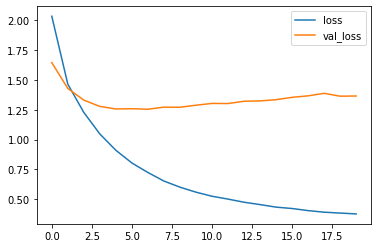

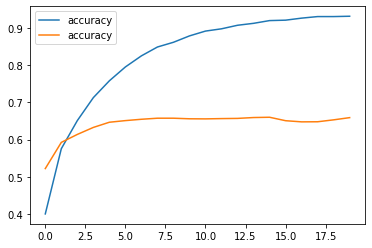

In [9]:
plot_history(model.history)

## Testing the model with custom input

In [10]:
model = load_model('model_LSTM_2.h5')

In [11]:
test_text = "Hot weather and sunshine"
pre_sentence = preprocess_sentence(test_text, tokenizer) # the sentence cannot be two words else it doesn't work
prediction(pre_sentence, model)

'Travel & Places'

In [12]:
prediction_table(pre_sentence, model)

+-----------------+-------------+
|     Category    | Probability |
+-----------------+-------------+
| Travel & Places |    98.67%   |
|    Activities   |    0.28%    |
|     Symbols     |    0.24%    |
+-----------------+-------------+
